In [28]:
import pandas as pd
import numpy as np
data = pd.read_csv('Micro-credit-Data-file.csv')
data = data.drop(columns=['Unnamed: 0'], errors='ignore')

In [30]:
date_cols = ['last_rech_date_ma', 'last_rech_date_da']
for col in date_cols:
    if col in data.columns:
        data[col].fillna(data[col].mode()[0], inplace=True)
payback_cols = ['payback30', 'payback90']
for col in payback_cols:
    if col in data.columns:
        data[col].fillna(0, inplace=True)

In [31]:
categorical_cols = ['msisdn', 'pcircle']
for col in categorical_cols:
    if col in data.columns:
        data[col] = data[col].astype('category')
if 'pdate' in data.columns:
    data['pdate'] = pd.to_datetime(data['pdate'], errors='coerce')

In [32]:
numerical_cols = data.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median_value = data[col].median()
    data[col] = np.where(data[col] < lower_bound, median_value, data[col])
    data[col] = np.where(data[col] > upper_bound, median_value, data[col])
data.info()
missing_summary = data.isnull().sum()
print(missing_summary[missing_summary > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209593 entries, 0 to 209592
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   label                 209593 non-null  float64       
 1   msisdn                209593 non-null  category      
 2   aon                   209593 non-null  float64       
 3   daily_decr30          209593 non-null  float64       
 4   daily_decr90          209593 non-null  float64       
 5   rental30              209593 non-null  float64       
 6   rental90              209593 non-null  float64       
 7   last_rech_date_ma     209593 non-null  float64       
 8   last_rech_date_da     209593 non-null  float64       
 9   last_rech_amt_ma      209593 non-null  float64       
 10  cnt_ma_rech30         209593 non-null  float64       
 11  fr_ma_rech30          209593 non-null  float64       
 12  sumamnt_ma_rech30     209593 non-null  float64       
 13 

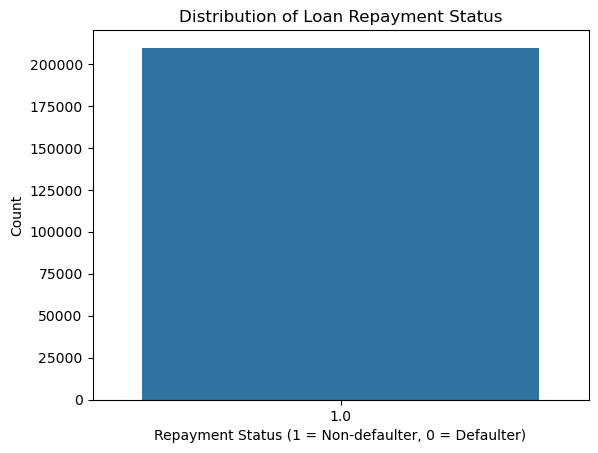

In [33]:
sns.countplot(x='label', data=data)
plt.title('Distribution of Loan Repayment Status')
plt.xlabel('Repayment Status (1 = Non-defaulter, 0 = Defaulter)')
plt.ylabel('Count')
plt.show()

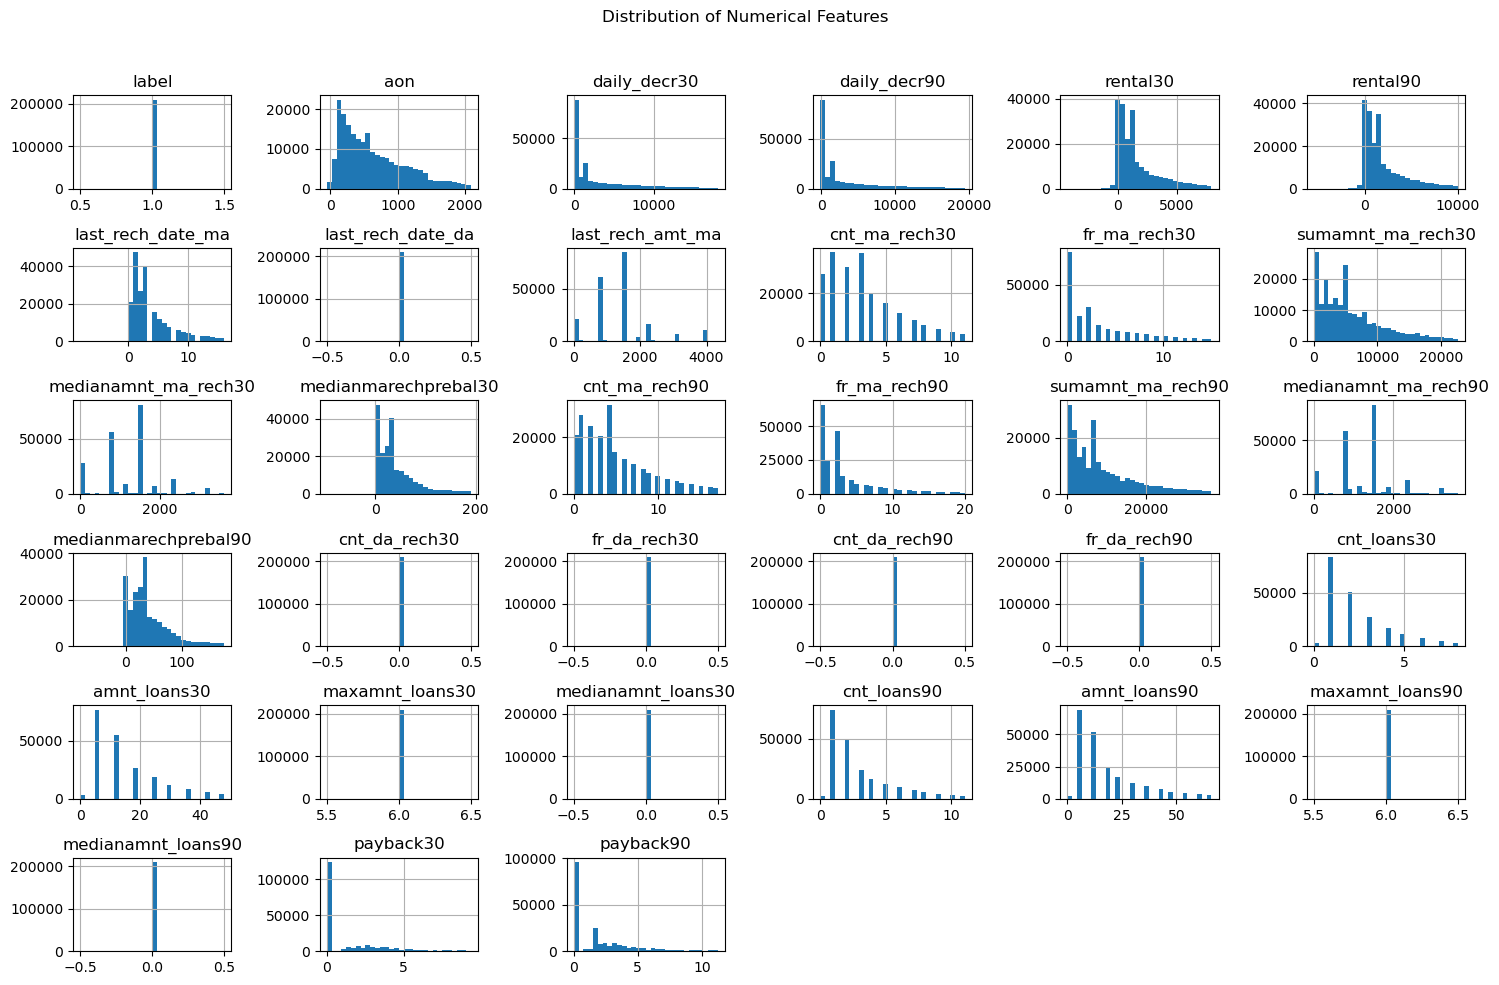

In [34]:
data.select_dtypes(include=[np.number]).hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


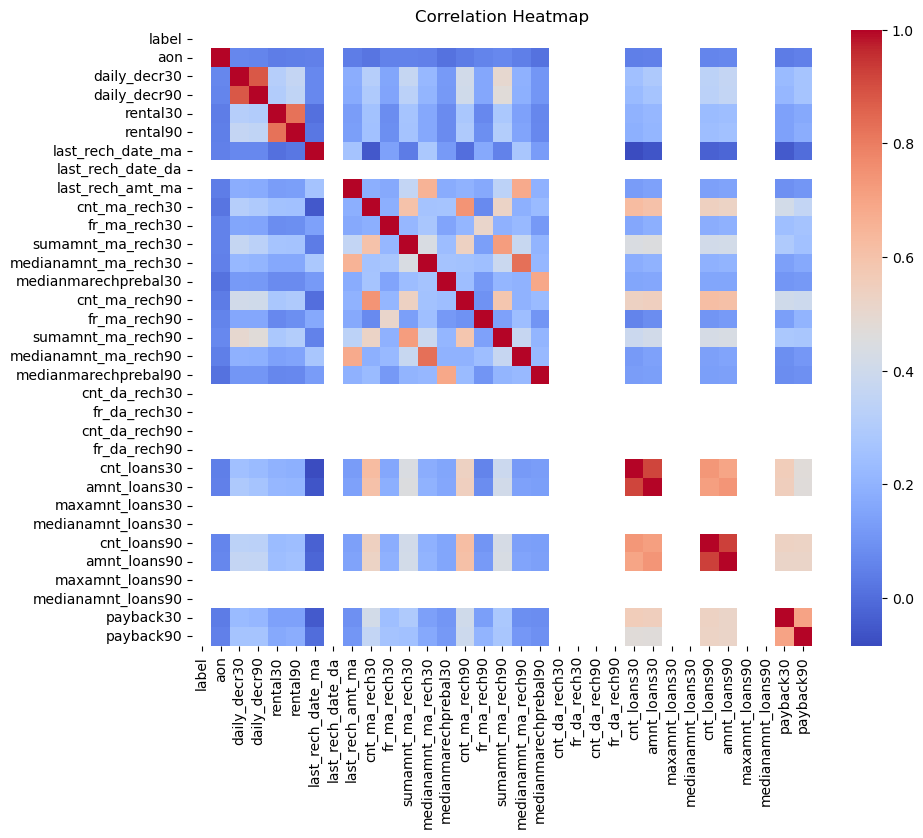

In [19]:
# 3. Correlation Heatmap
# Display correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(data.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

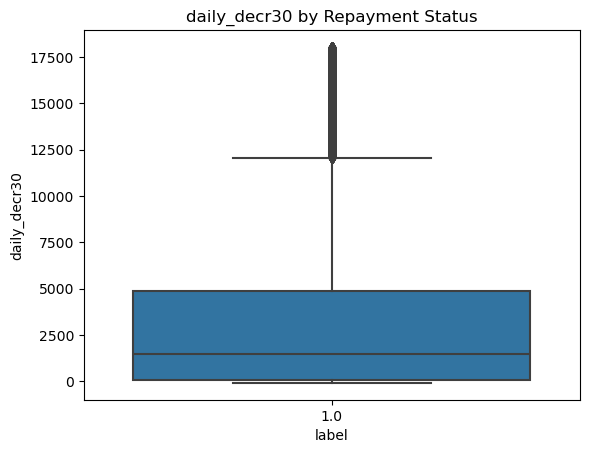

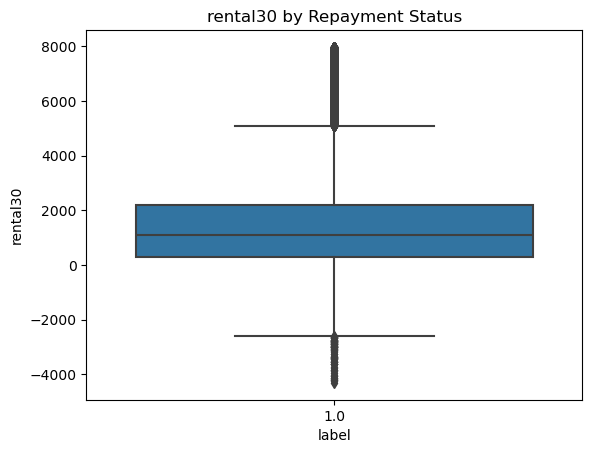

ValueError: Could not interpret input 'total_rech_amt_30'

In [20]:
# 4. Boxplot of Key Features by Repayment Status
# Choose a few numerical features to plot against the target
key_features = ['daily_decr30', 'rental30', 'total_rech_amt_30']  # Example features
for feature in key_features:
    sns.boxplot(x='label', y=feature, data=data)
    plt.title(f'{feature} by Repayment Status')
    plt.show()

In [35]:
try:
    data = pd.read_csv('Micro-credit-Data-file.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")

Data loaded successfully.


In [36]:
if 'total_rech_amt_30' in data.columns and 'total_rech_amt_90' in data.columns:
    data['total_rech_amt'] = data['total_rech_amt_30'] + data['total_rech_amt_90']
    data['avg_rech_amt'] = data['total_rech_amt'] / 2
else:
    print("Required columns for feature creation are missing.")

Required columns for feature creation are missing.


In [37]:
if 'total_rech_amt' in data.columns:
    data['log_total_rech_amt'] = np.log1p(data['total_rech_amt'])
else:
    print("Column 'total_rech_amt' is missing, cannot apply log transformation.")

Column 'total_rech_amt' is missing, cannot apply log transformation.


In [38]:
if 'pcircle' in data.columns:
    data['pcircle'] = data['pcircle'].astype('category').cat.codes
else:
    print("Column 'pcircle' is missing, cannot apply encoding.")

In [39]:
columns_to_drop = ['msisdn', 'total_rech_amt_30', 'total_rech_amt_90']
data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])
print(data.head())

   Unnamed: 0  label    aon  daily_decr30  daily_decr90  rental30  rental90  \
0           1      0  272.0   3055.050000   3065.150000    220.13    260.13   
1           2      1  712.0  12122.000000  12124.750000   3691.26   3691.26   
2           3      1  535.0   1398.000000   1398.000000    900.13    900.13   
3           4      1  241.0     21.228000     21.228000    159.42    159.42   
4           5      1  947.0    150.619333    150.619333   1098.90   1098.90   

   last_rech_date_ma  last_rech_date_da  last_rech_amt_ma  ...  \
0                2.0                0.0              1539  ...   
1               20.0                0.0              5787  ...   
2                3.0                0.0              1539  ...   
3               41.0                0.0               947  ...   
4                4.0                0.0              2309  ...   

   maxamnt_loans30  medianamnt_loans30  cnt_loans90  amnt_loans90  \
0              6.0                 0.0          2.0        

In [50]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss

In [51]:
# Display non-numeric columns to identify potential issues
non_numeric_columns = data.select_dtypes(include=['object']).columns
print("Non-numeric columns detected:", non_numeric_columns)

Non-numeric columns detected: Index([], dtype='object')


In [52]:
# Drop or encode non-numeric columns as necessary
# Assuming 'msisdn' or any other ID columns are identifiers, we drop them
data = data.drop(columns=non_numeric_columns)  # Drop non-numeric columns for simplicity



In [53]:
# Check if 'label' column exists in the data
if 'label' in data.columns:
    X = data.drop(columns=['label']) 
    y = data['label'] 
else:
    print("Error: Target variable 'label' is missing.")
    X, y = None, None

In [55]:
if X is not None and y is not None:
    model = LogisticRegression(max_iter=100)
    try:
        model.fit(X, y)
        print("Model training successful.")
    except Exception as e:
        print(f"Error during model training: {e}")
        
    try:
        y_pred = model.predict(X)
        y_proba = model.predict_proba(X)[:, 1]  
        print("Predictions successful.")
    except Exception as e:
        print(f"Error during prediction: {e}")


    try:
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        logloss = log_loss(y, y_proba)
        
        print("Model Evaluation Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Log Loss: {logloss:.4f}")
    except Exception as e:
        print(f"Error during evaluation: {e}")
else:
    print("Error: Model training skipped due to missing features or target.")


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model training successful.
Predictions successful.
Model Evaluation Metrics:
Accuracy: 0.8763
Precision: 0.8785
Recall: 0.9964
Log Loss: 0.3191


In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, f1_score, confusion_matrix
import pandas as pd

accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y, y_pred)
print(f"Precision: {precision:.4f}")

recall = recall_score(y, y_pred)
print(f"Recall: {recall:.4f}")

logloss = log_loss(y, y_proba)
print(f"Log Loss: {logloss:.4f}")

f1 = f1_score(y, y_pred)
print(f"F1 Score: {f1:.4f}")

conf_matrix = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8763
Precision: 0.8785
Recall: 0.9964
Log Loss: 0.3191
F1 Score: 0.9338
Confusion Matrix:
[[   894  25268]
 [   661 182770]]
